In [1]:
#Needed in general


import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py as h5
import gc

#Quick fudge to make import from ../Scripts work
sys.path.append('../Scripts')

#Custom imports
# import ClassCOMPAS     as CC ###
# import ClassFormationChannels as FC a


# import script that has formation channel classification functions:
from PostProcessingScripts import * 
# from ClassFormationChannels_5mainchannels import * 



from astropy import units as u
from astropy import constants as const

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# print(fs)

import astropy
import seaborn as sns
# from seaborn_utility import cmap_from_colour

from astropy import units as u
from astropy import constants as c

In [2]:
from KDEpy import FFTKDE
from scipy.stats import norm

# Generate a distribution and draw 2**6 data points


In [24]:






def plot_MRR_distribution_standout_check(axe='None', xparam='chiEff', BPSmodelName='A', mode='pdf',\
                          spin_threshold='None', bw=0.01, xlim=[0,1], ylim=[0,1],\
                          plotYlog='False', ylim_threshold=0.02, mssfr='112'):
    
#     labellist= np.ones(5) #,  r'$\log_{10}(t) $']      

    DCOtype='BBH'
    # path for files 
    path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
    
    fdata = h5.File(path, 'r')
    massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
    massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1
    
    seedsDCO  = fdata['doubleCompactObjects']['seed'][...].squeeze()  # get the seeds in the DCO file 
    seedsSN   = fdata['supernovae']['randomSeed'][...].squeeze()    # get the seeds in the SN file 
    indices   = np.sort(np.unique(seedsSN[1::2], return_index=True)[1])
    maskSNdco = np.in1d(seedsSN,  seedsDCO) # mask in the SNe files the SNe that correspond to our DCO
    whichSN   = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]  # this is 1 if the initially primary star goes SN and 2 if the secondary goes supernova     
    whichSN2  = whichSN[1::2][indices]

    # either SN2 = primary (1) and M1 is > M2, or SN2 = secondary & M1 < M2 
    # this takes into account (first term) rejuvenation 
    mask_MRR = ((whichSN2==1) & (massCO_ZAMSM1>massCO_ZAMSM2) ) | ((whichSN2==2) & (massCO_ZAMSM1<massCO_ZAMSM2)) 

    del massCO_ZAMSM1
    del massCO_ZAMSM2
    del whichSN2
    del whichSN
    del maskSNdco
    del indices
    del seedsSN
    del seedsDCO

    




    
    if (mode=='spin_PDF') | (mode=='spin_fraction') | (mode=='m1spin_or_m2spin_fraction') | (xparam=='chi_of_spinning_BH'):
        spin = COspin(data_path=path, state='he_depletion')  # set class 
        spin.setCOMPASData() # reads in the COMPAS DCO parameters 
        spinZAMSM1, spinZAMSM2  = spin.BaveraSpin() #ZAMS M1 SPIN 

        spinLVKM1, spinLVKM2 = np.zeros_like(spinZAMSM1), np.zeros_like(spinZAMSM1)
        spinLVKM1[mask_MRR] = spinZAMSM2[mask_MRR]  # MRR so M1 comes from M2ZAMS, we assign it spin from M2ZAMS
        spinLVKM1[~mask_MRR] = spinZAMSM1[~mask_MRR]  # no MRR so M1 comes from M1ZAMS, we assign it spin from M1ZAMS
        spinLVKM2[mask_MRR] = spinZAMSM1[mask_MRR]   # MRR so M2 comes from M1ZAMS, we assign it spin from M1ZAMS
        spinLVKM2[~mask_MRR] = spinZAMSM2[~mask_MRR]   # no MRR so M2 comes from M2ZAMS, we assign it spin from M2ZAMS     

        # spin_threshold = 0.05 # definition of "spinning BH"
        mask_LVKM1_spinning = (spinLVKM1 > spin_threshold ) 
        mask_LVKM2_spinning = (spinLVKM2 > spin_threshold ) # definition of "spinning BH"
        mask_anySpin = (spinLVKM1 > spin_threshold ) | (spinLVKM2 > spin_threshold )    

    fs_l = 20 # label fontsize

    if xparam=='chirp_mass_LVK':
        param_x = chirpmass(massCO_LVKM1, massCO_LVKM2)
        nameX = r'$\mathcal{M}_{\rm{c}} \ [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(1,100,1000)

    elif xparam=='mass_ratio_LVK':
        param_x = MassRatioCO_LVK
        nameX = r'$q$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(-0.2,1.2,1000)
        
    elif xparam=='chi_of_spinning_BH':
        param_x = spinLVKM1 + spinLVKM2

        nameX = r'$\chi_{\rm{BH}}$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(-0.2,2,1000)        
    
    if (mode=='MRR_PDF') | (mode=='spin_PDF'):
        nameY = r'\textbf{PDF}'
    elif (mode=='MRR_fraction'):
        nameY = r'\textbf{fraction MRR}'
    elif (mode=='spin_fraction'):
        nameY =  r'\textbf{fraction}' + '\n' + r'$\chi_{1} > %s$'%spin_threshold
    elif (mode=='m1spin_or_m2spin_fraction'):
        nameY =  r'\textbf{fraction}' + '\n' + r'$\chi_{\rm{BH}} > %s$'%spin_threshold  
    else:
        raise ValueError("the provided `mode` is not recognized, the value given is %s"%mode)
        
    
    estimator = FFTKDE(kernel='biweight', bw=bw)
    
    if plotYlog==True:       
        axe.set_yscale('log')
    
    for ind_mssfr, mssfr in enumerate([mssfr]):
        ### read in MSSFR weights: ###
        fparam_key = 'weights_detected'
        weightheader = 'w_' + mssfr
        weights_ = fdata[fparam_key][weightheader][...].squeeze()
        w = weights_

        if (mode=='MRR_PDF') | (mode=='MRR_fraction'): 
            yy_nonMRR = estimator.fit(param_x[~mask_MRR], weights=w[~mask_MRR]).evaluate(xx)
            yy_MRR = estimator.fit(param_x[mask_MRR], weights=w[mask_MRR]).evaluate(xx) 
            if mode=='MRR_PDF':
                rel_weight_nonMRR = np.sum(w[~mask_MRR]) / (np.sum(w))
                rel_weight_MRR    = np.sum(w[mask_MRR])  / (np.sum(w))
                yy_nonMRR *= rel_weight_nonMRR
                yy_MRR *= rel_weight_MRR
                
                
        elif (mode=='spin_PDF') | (mode=='spin_fraction'):
            yy_nonMRR = estimator.fit(param_x[mask_LVKM2_spinning], weights=w[mask_LVKM2_spinning]).evaluate(xx)
            yy_MRR = estimator.fit(param_x[mask_LVKM1_spinning], weights=w[mask_LVKM1_spinning]).evaluate(xx)
            if mode=='spin_PDF':
                rel_weight_nonMRR = np.sum(w[mask_LVKM2_spinning]) / (np.sum(w))
                rel_weight_MRR    = np.sum(w[mask_LVKM1_spinning])  / (np.sum(w))
                yy_nonMRR *= rel_weight_nonMRR
                yy_MRR *= rel_weight_MRR


        ## IF WE ARE PLOTTING PDFs
        if (mode=='MRR_PDF') | (mode=='spin_PDF'):
            if (mssfr in ['312']) & (BPSmodelName in ['A', 'B', 'K', 'S', 'T']):
                axe.plot(xx, yy_nonMRR, color='gold', lw=3, zorder=15, alpha=1, ls=':')
                axe.plot(xx, yy_MRR,    color='crimson', lw=3, zorder=16, alpha=1)
            else:
                axe.plot(xx, yy_nonMRR, color='lightgray', lw=1.5, zorder=5, alpha=1, ls=':')
                axe.plot(xx, yy_MRR,    color='k', lw=1.5, zorder=6, alpha=1)
                
            axe = layoutAxes(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=5, fontsize=fs_l)   
            
        # PLOTTING FRACTION     
        elif (mode=='MRR_fraction') | (mode=='spin_fraction'):
            yy_total = (yy_nonMRR + yy_MRR)
            # in some cases the overall PDF is so small, that the ratio is dominated by some shot noise. So we make those zero. 
            mask_too_small_values = (yy_nonMRR <ylim_threshold) & (yy_MRR < ylim_threshold)
            yy_MRR[mask_too_small_values] = np.zeros(int(np.sum(mask_too_small_values)))
            yy_nonMRR[mask_too_small_values] = np.zeros(int(np.sum(mask_too_small_values)))
            
            if (mssfr in ['312']) & (BPSmodelName in ['A', 'B', 'K', 'S', 'T']):
                axe.plot(xx, yy_MRR/yy_total,     color='crimson',        lw=3, zorder=20, alpha=1)
#                 if (mode=='spin_fraction'):
                axe.plot(xx, yy_nonMRR/yy_total,     color='gold',        lw=3, zorder=20, alpha=1)
            else:
                axe.plot(xx, yy_MRR/yy_total,     color='k',        lw=1.5, zorder=6, alpha=1)
#                 if (mode=='spin_fraction'):
                axe.plot(xx, yy_nonMRR/yy_total,    color='lightgray',        lw=1.5, zorder=6, alpha=1)
                    
            # remove labels and ticks  on X axe
            axe = layoutAxesNoXlabel(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=25, fontsize=fs_l)
            for tick in axe.xaxis.get_major_ticks():
                tick.tick1line.set_visible(False)
                tick.tick2line.set_visible(False)
                tick.label1.set_visible(False)
                tick.label2.set_visible(False)
                
#             axe.set_ylim(bottom=0, top=1)
                
    
        elif (mode=='m1spin_or_m2spin_fraction'):
            
            yy_total = estimator.fit(param_x, weights=w).evaluate(xx)
            yy_anySpin = estimator.fit(param_x[mask_anySpin], weights=w[mask_anySpin]).evaluate(xx)
           
            
            # in some cases the overall PDF is so small, that the ratio is dominated by some shot noise. So we make those zero. 
            mask_too_small_values = (yy_anySpin < ylim_threshold) & (yy_total < ylim_threshold)
            yy_anySpin[mask_too_small_values] = np.zeros(int(np.sum(mask_too_small_values)))
            
            if (mssfr in ['312', '231']) & (BPSmodelName in ['A', 'B', 'K', 'S', 'T']):
                axe.plot(xx, yy_anySpin*np.sum(w[mask_anySpin]) / (yy_total*np.sum(w)),     color='k',        lw=2, zorder=20, alpha=1)
            else:
                axe.plot(xx, yy_anySpin*np.sum(w[mask_anySpin]) / (yy_total*np.sum(w)),     color='gray',        lw=2, zorder=6, alpha=0.1)

                    
            # remove labels and ticks  on X axe
            axe = layoutAxesNoXlabel(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=25, fontsize=fs_l)
            for tick in axe.xaxis.get_major_ticks():
                tick.tick1line.set_visible(False)
                tick.tick2line.set_visible(False)
                tick.label1.set_visible(False)
                tick.label2.set_visible(False)



            
    axe.set_xlim(xlim[0], xlim[1])
    axe.set_ylim(ylim[0], ylim[1])
    axe.grid(True)
    

    
    return axe 









In [27]:






def plot_MRR_distribution(axe='None', xparam='chiEff', BPSmodelName='A', mode='pdf',\
                          spin_threshold='None', bw=0.01, xlim=[0,1], ylim=[0,1],\
                          plotYlog='False', ylim_threshold=0.02):#, mssfr='112'):
    
#     labellist= np.ones(5) #,  r'$\log_{10}(t) $']      
    
    
    
#     colors = ['royalblue', 'crimson']
    colors = ['#1f77b4', '#ff7f0e']
    colors_lighter = [adjust_lightness(color=colors[0], amount=2.0),adjust_lightness(color=colors[1], amount=1.6)]

    DCOtype='BBH'
    # path for files 
    path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
    
    fdata = h5.File(path, 'r')
    massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
    massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1
    
    seedsDCO  = fdata['doubleCompactObjects']['seed'][...].squeeze()  # get the seeds in the DCO file 
    seedsSN   = fdata['supernovae']['randomSeed'][...].squeeze()    # get the seeds in the SN file 
    indices   = np.sort(np.unique(seedsSN[1::2], return_index=True)[1])
    maskSNdco = np.in1d(seedsSN,  seedsDCO) # mask in the SNe files the SNe that correspond to our DCO
    whichSN   = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]  # this is 1 if the initially primary star goes SN and 2 if the secondary goes supernova     
    whichSN2  = whichSN[1::2][indices]

    # either SN2 = primary (1) and M1 is > M2, or SN2 = secondary & M1 < M2 
    # this takes into account (first term) rejuvenation 
    mask_MRR = ((whichSN2==1) & (massCO_ZAMSM1>massCO_ZAMSM2) ) | ((whichSN2==2) & (massCO_ZAMSM1<massCO_ZAMSM2)) 

    del massCO_ZAMSM1
    del massCO_ZAMSM2
    del whichSN2
    del whichSN
    del maskSNdco
    del indices
    del seedsSN
    del seedsDCO

    




    
    if (mode=='spin_PDF') | (mode=='spin_fraction') | (mode=='m1spin_or_m2spin_fraction') | (xparam=='chi_of_spinning_BH'):
        spin = COspin(data_path=path, state='he_depletion')  # set class 
        spin.setCOMPASData() # reads in the COMPAS DCO parameters 
        spinZAMSM1, spinZAMSM2  = spin.BaveraSpin() #ZAMS M1 SPIN 

        spinLVKM1, spinLVKM2 = np.zeros_like(spinZAMSM1), np.zeros_like(spinZAMSM1)
        spinLVKM1[mask_MRR] = spinZAMSM2[mask_MRR]  # MRR so M1 comes from M2ZAMS, we assign it spin from M2ZAMS
        spinLVKM1[~mask_MRR] = spinZAMSM1[~mask_MRR]  # no MRR so M1 comes from M1ZAMS, we assign it spin from M1ZAMS
        spinLVKM2[mask_MRR] = spinZAMSM1[mask_MRR]   # MRR so M2 comes from M1ZAMS, we assign it spin from M1ZAMS
        spinLVKM2[~mask_MRR] = spinZAMSM2[~mask_MRR]   # no MRR so M2 comes from M2ZAMS, we assign it spin from M2ZAMS     

        # spin_threshold = 0.05 # definition of "spinning BH"
        mask_LVKM1_spinning = (spinLVKM1 > spin_threshold ) 
        mask_LVKM2_spinning = (spinLVKM2 > spin_threshold ) # definition of "spinning BH"
        mask_anySpin = (spinLVKM1 > spin_threshold ) | (spinLVKM2 > spin_threshold )    

    fs_l = 20 # label fontsize

    if xparam=='chirp_mass_LVK':
        param_x = chirpmass(massCO_LVKM1, massCO_LVKM2)
        nameX = r'$\mathcal{M}_{\rm{c}} \ [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(1,100,1000)

    elif xparam=='mass_ratio_LVK':
        param_x = MassRatioCO_LVK
        nameX = r'$q$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(-0.2,1.2,1000)
        
    elif xparam=='chi_of_spinning_BH':
        param_x = spinLVKM1 + spinLVKM2

        nameX = r'$\chi_{\rm{BH}}$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(-0.2,2,1000)        
    
    if (mode=='MRR_PDF') | (mode=='spin_PDF'):
        nameY = r'\textbf{PDF}'
    elif (mode=='MRR_fraction'):
        nameY = r'\textbf{fraction MRR}'
    elif (mode=='spin_fraction'):
        nameY =  r'\textbf{fraction}' + '\n' + r'$\chi_{1} > %s$'%spin_threshold
    elif (mode=='m1spin_or_m2spin_fraction'):
        nameY =  r'\textbf{fraction}' + '\n' + r'$\chi_{\rm{BH}} > %s$'%spin_threshold  
    else:
        raise ValueError("the provided `mode` is not recognized, the value given is %s"%mode)
        
    
    estimator = FFTKDE(kernel='biweight', bw=bw)
    
    if plotYlog==True:       
        axe.set_yscale('log')
    
    for ind_mssfr, mssfr in enumerate(MSSFRnameslist[0:]):
        ### read in MSSFR weights: ###
        fparam_key = 'weights_detected'
        weightheader = 'w_' + mssfr
        weights_ = fdata[fparam_key][weightheader][...].squeeze()
        w = weights_

        if (mode=='MRR_PDF') | (mode=='MRR_fraction'): 
            yy_nonMRR = estimator.fit(param_x[~mask_MRR], weights=w[~mask_MRR]).evaluate(xx)
            yy_MRR = estimator.fit(param_x[mask_MRR], weights=w[mask_MRR]).evaluate(xx) 
            if mode=='MRR_PDF':
                rel_weight_nonMRR = np.sum(w[~mask_MRR]) / (np.sum(w))
                rel_weight_MRR    = np.sum(w[mask_MRR])  / (np.sum(w))
                yy_nonMRR *= rel_weight_nonMRR
                yy_MRR *= rel_weight_MRR
                
                
        elif (mode=='spin_PDF') | (mode=='spin_fraction'):
            yy_nonMRR = estimator.fit(param_x[mask_LVKM2_spinning], weights=w[mask_LVKM2_spinning]).evaluate(xx)
            yy_MRR = estimator.fit(param_x[mask_LVKM1_spinning], weights=w[mask_LVKM1_spinning]).evaluate(xx)
            if mode=='spin_PDF':
                rel_weight_nonMRR = np.sum(w[mask_LVKM2_spinning]) / (np.sum(w))
                rel_weight_MRR    = np.sum(w[mask_LVKM1_spinning])  / (np.sum(w))
                yy_nonMRR *= rel_weight_nonMRR
                yy_MRR *= rel_weight_MRR


        ## IF WE ARE PLOTTING PDFs
        if (mode=='MRR_PDF') | (mode=='spin_PDF'):
            if (mssfr in ['312']) & (BPSmodelName in ['A', 'B', 'K', 'S', 'T']):
                axe.plot(xx, yy_nonMRR, color=colors[0], lw=3, zorder=15, alpha=1, ls=':')
                axe.plot(xx, yy_MRR,    color=colors[1], lw=3, zorder=16, alpha=1)
            else:
                axe.plot(xx, yy_nonMRR, color='lightsteelblue', lw=1.5, zorder=5, alpha=1, ls=':')
                axe.plot(xx, yy_MRR,    color=colors_lighter[1], lw=1.5, zorder=6, alpha=1)
                
            axe = layoutAxes(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=5, fontsize=fs_l)   
            
        # PLOTTING FRACTION     
        elif (mode=='MRR_fraction') | (mode=='spin_fraction'):
            yy_total = (yy_nonMRR + yy_MRR)
            # in some cases the overall PDF is so small, that the ratio is dominated by some shot noise. So we make those zero. 
            mask_too_small_values = (yy_nonMRR <ylim_threshold) & (yy_MRR < ylim_threshold)
            yy_MRR[mask_too_small_values] = np.zeros(int(np.sum(mask_too_small_values)))
            yy_nonMRR[mask_too_small_values] = np.zeros(int(np.sum(mask_too_small_values)))
            
            if (mssfr in ['312']) & (BPSmodelName in ['A', 'B', 'K', 'S', 'T']):
                axe.plot(xx, yy_MRR/yy_total,     color=colors[1],        lw=3, zorder=20, alpha=1)
#                 if (mode=='spin_fraction'):
#                 axe.plot(xx, yy_nonMRR/yy_total,     color='gold',        lw=3, zorder=20, alpha=1)
            else:
                axe.plot(xx, yy_MRR/yy_total,     color=colors_lighter[1],        lw=1.5, zorder=6, alpha=1)
#                 if (mode=='spin_fraction'):
#                 axe.plot(xx, yy_nonMRR/yy_total,    color='lightgray',        lw=1.5, zorder=6, alpha=1)
                    
            # remove labels and ticks  on X axe
            axe = layoutAxesNoXlabel(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=25, fontsize=fs_l)
            for tick in axe.xaxis.get_major_ticks():
                tick.tick1line.set_visible(False)
                tick.tick2line.set_visible(False)
                tick.label1.set_visible(False)
                tick.label2.set_visible(False)
                
#             axe.set_ylim(bottom=0, top=1)
                
    
        elif (mode=='m1spin_or_m2spin_fraction'):
            
            yy_total = estimator.fit(param_x, weights=w).evaluate(xx)
            yy_anySpin = estimator.fit(param_x[mask_anySpin], weights=w[mask_anySpin]).evaluate(xx)
           
            
            # in some cases the overall PDF is so small, that the ratio is dominated by some shot noise. So we make those zero. 
            mask_too_small_values = (yy_anySpin < ylim_threshold) & (yy_total < ylim_threshold)
            yy_anySpin[mask_too_small_values] = np.zeros(int(np.sum(mask_too_small_values)))
            
            if (mssfr in ['312', '231']) & (BPSmodelName in ['A', 'B', 'K', 'S', 'T']):
                axe.plot(xx, yy_anySpin*np.sum(w[mask_anySpin]) / (yy_total*np.sum(w)),     color='k',        lw=2, zorder=20, alpha=1)
            else:
                axe.plot(xx, yy_anySpin*np.sum(w[mask_anySpin]) / (yy_total*np.sum(w)),     color='gray',        lw=2, zorder=6, alpha=0.1)

                    
            # remove labels and ticks  on X axe
            axe = layoutAxesNoXlabel(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=25, fontsize=fs_l)
            for tick in axe.xaxis.get_major_ticks():
                tick.tick1line.set_visible(False)
                tick.tick2line.set_visible(False)
                tick.label1.set_visible(False)
                tick.label2.set_visible(False)



            
    axe.set_xlim(xlim[0], xlim[1])
    axe.set_ylim(ylim[0], ylim[1])
    axe.grid(True)
    

    
    return axe 









# As a function of MRR fraction


### CHIRP MASS 

running model A


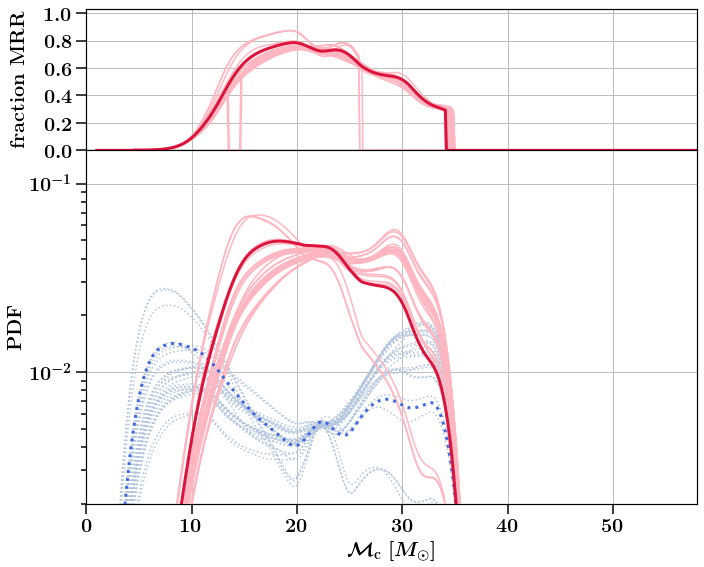

In [28]:

### CHIRP MASS VS SPINS FRACTION ###


fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




bw=0.85
ylim_threshold = 0.004

# for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):

for ind_BPS, BPSmodel in enumerate(['A']):
    
    print('running model %s'%BPSmodel)
    xparam = 'chirp_mass_LVK'
    
    plotYlog = False
    xlim, ylim = [0, 58], [0.0, 1.03]
    
#     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
#                                   spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
    plotYlog = True
    ylim = [0.003, 0.15]
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_PDF',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


# plt.savefig('./' + xparam    + '_MRR_split.pdf', transparent=False, bbox_inches="tight",  format='pdf')
# plt.savefig('./' + xparam    +  '_MRR_split.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






In [ ]:

### CHIRP MASS VS SPINS FRACTION ###

for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):
    for ind_mssfr, mssfr in enumerate(MSSFRlist):
        fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})#,\
        #                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})
        bw=0.85
        ylim_threshold = 0.02


        # for ind_BPS, BPSmodel in enumerate(['A', 'B', 'K', 'S', 'T']):

            print('running model %s'%BPSmodel)
            xparam = 'chirp_mass_LVK'

            plotYlog = False
            xlim, ylim = [0, 58], [0.0, 1.03]

        #     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
        #                                   spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
            ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction',\
                                          spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold, mssfr=mssfr) 
            plotYlog = True
            ylim = [0.002, 0.15]
            ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_PDF',\
                                          spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold, mssfr=mssfr)


        plt.tight_layout()  
        plt.subplots_adjust(wspace=0, hspace=0)#2)


        plt.savefig('./standout/' + xparam  + mssfr  +  '_MRR_split.pdf', transparent=False, bbox_inches="tight",  format='pdf')
        plt.savefig('./standout/' + xparam  + mssfr  +  '_MRR_split.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
        # plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
        plt.show() 
        plt.close()






In [ ]:

# ### CHIRP MASS VS SPINS FRACTION ###


# fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})#,\
# #                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




# bw=0.85
# ylim_threshold = 0.01

# for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):
# # for ind_BPS, BPSmodel in enumerate(['A', 'B', 'K', 'S', 'T']):
    
#     print('running model %s'%BPSmodel)
#     xparam = 'chirp_mass_LVK'
    
#     plotYlog = True
#     xlim, ylim = [0, 58], [0.04, 1.03]
    
# #     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
# #                                   spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
#     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction',\
#                                   spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
#     plotYlog = True
#     ylim = [0.002, 0.15]
#     ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_PDF',\
#                                   spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold)

    
# plt.tight_layout()  
# plt.subplots_adjust(wspace=0, hspace=0)#2)


# plt.savefig('./' + xparam   +  '_MRR_log_temp.pdf', transparent=False, bbox_inches="tight",  format='pdf')
# plt.savefig('./' + xparam   +  '_MRR_log_temp.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# # plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
# plt.show()  






### mass ratio

In [ ]:

### CHIRP MASS VS SPINS FRACTION ###


fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
# xparam='ChiEff'
model='A'

ylim_threshold = 0.01
bw = 0.01 

for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):
# for ind_BPS, BPSmodel in enumerate(['A', 'B', 'K', 'S', 'T']):
    
    print('running model %s'%BPSmodel)
    xparam = 'mass_ratio_LVK'
    
    plotYlog = False
    xlim, ylim = [0, 1], [0.0, 1.03]
    
#     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
#                                   spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
    plotYlog = False
    ylim = [0., 6.15]
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_PDF',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '_MRR_NoTlog_temp.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_MRR_NoTlog_temp.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






In [ ]:

### CHIRP MASS VS SPINS FRACTION ###


fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
# xparam='ChiEff'
model='A'

ylim_threshold = 0.01
bw = 0.01 

for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):
# for ind_BPS, BPSmodel in enumerate(['A', 'B', 'K', 'S', 'T']):
    
    print('running model %s'%BPSmodel)
    xparam = 'mass_ratio_LVK'
    
    plotYlog = True
    xlim, ylim = [0, 1], [0.04, 1.03]
    
#     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
#                                   spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
    plotYlog = True
    ylim = [0.1, 9.15]
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_PDF',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '_MRR_log_temp.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_MRR_log_temp.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






### Spin of Spinning BH 

In [ ]:

### CHIRP MASS VS SPINS FRACTION ###


fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
# xparam='ChiEff'
model='A'

ylim_threshold = 0.01
bw = 0.011
xparam = 'chi_of_spinning_BH'

for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):
# for ind_BPS, BPSmodel in enumerate(['A', 'B', 'K', 'S', 'T']):
    
    print('running model %s'%BPSmodel)
    
    
    plotYlog = True
    xlim, ylim = [0, 1], [0.04, 1.03]
    
#     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
#                                   spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
    plotYlog = True
    ylim = [0.01, 18.15]
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_PDF',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '_MRR_log_temp.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_MRR_log_temp.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






In [ ]:

### CHIRP MASS VS SPINS FRACTION ###


fig, ax = plt.subplots(3,1, figsize=(12,8), gridspec_kw={"height_ratios":[1,1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
# xparam='ChiEff'
model='A'


for ind_BPS, BPSmodel in enumerate([BPSnameslist[0]]):
    
    print('running model %s'%BPSmodel)
    xparam = 'chirp_mass_LVK'
    
    plotYlog = False
    xlim, ylim = [0, 40], [0.01, 1]
    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
                                  spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_fraction',\
                                  spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
    plotYlog = True
    ylim = [0.001, 0.03]
    ax[2] = plot_MRR_distribution(axe=ax[2], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_PDF',\
                                  spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '_spins_log_temp.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_spins_log_temp.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






In [ ]:
fig, ax = plt.subplots(3,1, figsize=(12,8), gridspec_kw={"height_ratios":[1,1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
# xparam='ChiEff'
model='A'


for ind_BPS, BPSmodel in enumerate([BPSnameslist[0]]):
    
    print('running model %s'%BPSmodel)
    xparam = 'mass_ratio_LVK'

    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction', spin_threshold=0.05, bw=0.01) 
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_fraction', spin_threshold=0.05, bw=0.04) 
    ax[2] = plot_MRR_distribution(axe=ax[2], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_PDF',      spin_threshold=0.05, bw=0.04)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


# plt.savefig('./' + xparam   +  '_spins_log.pdf', transparent=False, bbox_inches="tight",  format='pdf')
# plt.savefig('./' + xparam   +  '_spins_log.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
# xparam='ChiEff'
model='A'


for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):
    
    print('running model %s'%BPSmodel)
    xparam = 'chirp_mass_LVK'

#     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction', spin_threshold=0.05, bw=0.01) 
    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction', spin_threshold=0.05, bw=0.24) 
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_PDF',      spin_threshold=0.05, bw=0.24)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '_MRR_.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_MRR_.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






# Chi fraction 

In [ ]:

### CHIRP MASS VS SPINS FRACTION ###


fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
# xparam='ChiEff'
model='A'

ylim_threshold = 0.01
bw = 0.01 

for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):
# for ind_BPS, BPSmodel in enumerate(['A', 'B', 'K', 'S', 'T']):
    
    print('running model %s'%BPSmodel)
    xparam = 'mass_ratio_LVK'
    
    plotYlog = False
    xlim, ylim = [0, 1], [0.0, 1.03]
    
#     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
#                                   spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
    plotYlog = False
    ylim = [0., 6.15]
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_PDF',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '_MRR_NoTlog_temp.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_MRR_NoTlog_temp.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






In [ ]:
fig, ax = plt.subplots(3,1, figsize=(12,8), gridspec_kw={"height_ratios":[1,1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




ylim_threshold = 0.01
bw = 0.01 

for ind_BPS, BPSmodel in enumerate(BPSnameslist[:2]):
    
    print('running model %s'%BPSmodel)
    xparam = 'mass_ratio_LVK'
    
    plotYlog = True
    xlim, ylim = [0, 1], [0.0, 1.03]
    

    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction', spin_threshold=0.05, bw=0.01) 
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_fraction', spin_threshold=0.05, bw=0.04) 
    ax[2] = plot_MRR_distribution(axe=ax[2], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_PDF',      spin_threshold=0.05, bw=0.04)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '_spins_log_2.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_spins_log_2.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






In [ ]:





mssfr = '112' # mssfr that matches LIGO observed rates.
# xparam='ChiEff'
model='A'


for ind_BPS, BPSmodel in enumerate(BPSnameslist[:2]):
    fig, ax = plt.subplots(3,1, figsize=(12,8), gridspec_kw={"height_ratios":[1,1, 2.5]})#,\
    #                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})
    
    print('running model %s'%BPSmodel)
    xparam = 'mass_ratio_LVK'

    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction', spin_threshold=0.05, bw=0.01) 
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_fraction', spin_threshold=0.05, bw=0.04) 
    ax[2] = plot_MRR_distribution(axe=ax[2], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_PDF',      spin_threshold=0.05, bw=0.04)

    
    plt.tight_layout()  
    plt.subplots_adjust(wspace=0, hspace=0)#2)


#     plt.savefig('./' + xparam   +  '_spins_log_' + BPSmodel + '.pdf', transparent=False, bbox_inches="tight",  format='pdf')
#     plt.savefig('./' + xparam   +  '_spins_log_' + BPSmodel + '.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
    # plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
    plt.show()  






In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
# xparam='ChiEff'
model='A'


for ind_BPS, BPSmodel in enumerate(BPSnameslist[0:]):
    
    print('running model %s'%BPSmodel)
    xparam = 'mass_ratio_LVK'

    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_fraction', spin_threshold=0.05) 
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_PDF',      spin_threshold=0.05)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '_spins.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_spins.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(8,8))#,\
# #                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




# mssfr = '112' # mssfr that matches LIGO observed rates.
# # xparam='ChiEff'
# model='A'


# for ind_BPS, BPSmodel in enumerate(BPSnameslist):
#     print('running model %s'%BPSmodel)
#     # for ax_ind, model in enumerate(['A', 'G', 'J', 'K', 'R']):
#     xparam = 'mass_ratio_LVK'
#     ax = plot_PDF(axe=ax, xparam=xparam, BPSmodelName=BPSmodel) #, mssfr=None)

    
# plt.tight_layout()  
# plt.subplots_adjust(wspace=0, hspace=0)#2)


# plt.savefig('./' + xparam   +  '.eps', transparent=False, bbox_inches="tight", dpi=600, format='eps')
# plt.show()  

In [ ]:






# def plot_fraction(axe='None', xparam='chiEff', BPSmodelName='A'):#, mssfr='112'):
    
# #     labellist= np.ones(5) #,  r'$\log_{10}(t) $']      

#     DCOtype='BBH'
#     # path for files 
#     path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
#     path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
    
    
#     # read in data 
#     fdata = h5.File(path)
    
#     massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
#     massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
#     # M1 will be the most massive, M2 the least massive compact object. 
#     massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
#     MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1


        
# #     spin = COspin(data_path=path, state='he_depletion')  # set class 
# #     spin.setCOMPASData() # reads in the COMPAS DCO parameters 
# #     spinZAMSM1, spinZAMSM2  = spin.BaveraSpin() #ZAMS M1 SPIN 
    
    
# #     maxSpinBBH = np.maximum(spinZAMSM1,spinZAMSM2)
# #     mask_ = (maxSpinBBH >0)
# #     print('\t non-zero spin:', np.sum(mask_), 'out of ', len(mask_), 'BBHs')
# #     mask_ = (maxSpinBBH >0.2)
# #     print('\t a spin >.2: ', np.sum(mask_), 'out of ', len(mask_), 'BBHs')
    
#     mask_MRR = (massCO_ZAMSM1/massCO_ZAMSM2) < 1



#     fs_l = 20 # label fontsize

#     if xparam=='ChiEff_vs_q':
#         axe.set_xlim(-0.06, 1.05)
#         axe.set_ylim(0, 1)  
#         chi_eff = ((spinZAMSM1 *massCO_ZAMSM1) + spinZAMSM2*massCO_ZAMSM2) / (massCO_ZAMSM1+massCO_ZAMSM2)
#         param_x = chi_eff
#         param_y = MassRatioCO_LVK
#         nameX = r'$\chi_{\rm{eff}}$'
#         nameY = r'$q$'

#     if xparam=='mass_ratio_LVK':
#         param_x = MassRatioCO_LVK
#         nameX = r'$q$'
#         nameY = r'\textbf{fraction MRR}'
#         xx = np.linspace(-0.2,1.2,1000)
#         axe.set_xlim(0,1)
        

#     COLOR=False   
#     for ind_mssfr, mssfr in enumerate(MSSFRnameslist):
#         ### read in MSSFR weights: ###
#         fparam_key = 'weights_detected'
#         weightheader = 'w_' + mssfr
#         weights_ = fdata[fparam_key][weightheader][...].squeeze()
#         w = weights_
#         w_total = np.sum(w)

#         estimator = FFTKDE(kernel='biweight', bw=0.01)
        
#         yy_nonMRR = estimator.fit(param_x[~mask_MRR], weights=w[~mask_MRR]).evaluate(xx) * np.sum(w[~mask_MRR])/w_total
#         yy_MRR = estimator.fit(param_x[mask_MRR], weights=w[mask_MRR]).evaluate(xx)  * np.sum(w[mask_MRR])/w_total 
# #         print('should be 1 : ', (np.sum(yy_nonMRR)+ np.sum(yy_MRR)))
#         yy_total = (yy_nonMRR + yy_MRR)
    
#         # in some cases the non MRR is so small, that the ratio is dominated by some shot noise in MRR. So we make those zero. 
#         mask_too_small_values = (yy_nonMRR < 10**(-4))
#         yy_MRR[mask_too_small_values] = np.zeros(int(np.sum(mask_too_small_values)))
        
#         if (mssfr in ['312', '231']) & (BPSmodelName in ['A', 'B', 'K', 'S', 'T']):
#             axe.plot(xx, yy_MRR/yy_total,    label='MRR',     color='crimson',        lw=2, zorder=20, alpha=1)
#         else:
#             axe.plot(xx, yy_MRR/yy_total,    label='MRR',     color='k',        lw=2, zorder=6, alpha=0.1)
            

#     axe.grid(True)
    
# #     if BPSmodelName=='A':
#     axe = layoutAxesNoXlabel(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=15, fontsize=fs_l)
# #     else:
# #         axe = layoutAxesNoYlabel(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=10, fontsize=fs_l)

#     for tick in axe.xaxis.get_major_ticks():
#         tick.tick1line.set_visible(False)
#         tick.tick2line.set_visible(False)
#         tick.label1.set_visible(False)
#         tick.label2.set_visible(False)


    
    
# #     axe.text(0+0.009, 0.009, r'\textbf{model %s} %s'%(BPSmodelName,alphabetPhysicalNameDict[BPSmodelName]) , rotation = 0, fontsize = fs-2, color = 'k', ha = 'left', va='bottom', transform=axe.transAxes, zorder=100)#, weight = 'bold')
    
# #     plt.legend(fontsize=fs_l, loc=3)
    
    
  
    
#     return axe 









In [ ]:
# fig, ax = plt.subplots(2,1, figsize=(10,10), gridspec_kw={"height_ratios":[1, 3]})#,\
# #                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




# mssfr = '112' # mssfr that matches LIGO observed rates.
# # xparam='ChiEff'
# model='A'


# for ind_BPS, BPSmodel in enumerate(BPSnameslist[0:]):
    
#     print('running model %s'%BPSmodel)
#     xparam = 'mass_ratio_LVK'

#     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction') 
#     ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='pdf')

    
# # plt.tight_layout()  
# plt.subplots_adjust(wspace=0, hspace=0)#2)

# plt.savefig('./' + xparam   +  'fraction.pdf', transparent=False, bbox_inches="tight",  format='pdf')
# plt.savefig('./' + xparam   +  'fraction.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# # plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
# plt.show()  

In [ ]:



for ind_BPS, BPSmodel in enumerate(BPSnameslist[0:]):
    
    
    
    
    fig, ax = plt.subplots(2,1, figsize=(10,10), gridspec_kw={"height_ratios":[1, 3]})#,\

    print('running model %s'%BPSmodel)
    xparam = 'mass_ratio_LVK'
    ax[1] = plot_PDF(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel) #, mssfr=None)
    ax[0] = plot_fraction(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel) #, mssfr=None)

    
    # plt.tight_layout()  
    plt.subplots_adjust(wspace=0, hspace=0)#2)


    # plt.savefig('./' + xparam   +  'fraction.eps', transparent=False, bbox_inches="tight", dpi=600, format='eps')
    plt.show()  